Data Preprocessing

In [52]:
!pip install mtcnn

In [ ]:
from mtcnn import MTCNN
import cv2
import numpy as np
import os
from shutil import copyfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the MTCNN face detection model
mtcnn = MTCNN()

# Function to detect faces in an image and save the processed skin image
def detect_and_process_skin(image_path, output_folder, label):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image '{image_path}'. Skipping.")
        return False

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    detections = mtcnn.detect_faces(img_rgb)

    # Check if any faces were detected
    if detections:
        # Extract the first detected face
        x, y, width, height = detections[0]['box']

        # Crop the face region
        face_img = img[y:y+height, x:x+width]

        # Process skin regions within the cropped face image
        processed_skin_image = process_skin_regions(face_img)

        # Save the processed skin image
        output_skin_path = os.path.join(output_folder, label, f"processed_skin_{os.path.basename(image_path)}")
        cv2.imwrite(output_skin_path, processed_skin_image)
        print(f"Processed skin image saved successfully: {output_skin_path}")
        return True
    else:
        print(f"No faces were detected in the image: {image_path}")
        # If no faces are detected, extract skin regions or save the original image
        skin_mask = skin_detection(img)
        if np.any(skin_mask):
            # Extract skin regions using the mask
            skin_regions = cv2.bitwise_and(img, img, mask=skin_mask)
            output_skin_path = os.path.join(output_folder, label, f"processed_skin_{os.path.basename(image_path)}")
            cv2.imwrite(output_skin_path, skin_regions)
            print(f"Processed skin image saved successfully: {output_skin_path}")
        else:
            # Save the original image if no skin regions are detected
            output_original_path = os.path.join(output_folder, label, f"original_{os.path.basename(image_path)}")
            cv2.imwrite(output_original_path, img)
            print(f"No skin regions detected. Original image saved: {output_original_path}")
        return False

# Function to detect skin regions in an image
def skin_detection(image):
    # Convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define lower and upper thresholds for skin color in YCrCb space
    lower = np.array([0, 135, 85], dtype=np.uint8)
    upper = np.array([255, 180, 135], dtype=np.uint8)

    # Create a binary mask to detect skin regions
    mask = cv2.inRange(ycrcb, lower, upper)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

# Function to process skin regions in an image
def process_skin_regions(image):
    # Detect skin regions in the image
    skin_mask = skin_detection(image)

    # Extract the skin regions using the mask
    skin_regions = cv2.bitwise_and(image, image, mask=skin_mask)

    return skin_regions

# Function to process a set of images
def process_images(image_paths, output_folder):
    for image_path in image_paths:
        # Determine the label from the folder name
        label = os.path.basename(os.path.dirname(image_path))
        # Create the corresponding output folder if it doesn't exist
        output_label_folder = os.path.join(output_folder, label)
        os.makedirs(output_label_folder, exist_ok=True)
        detect_and_process_skin(image_path, output_folder, label)

# Path to the input folder
input_folder = '/content/drive/My Drive/skin_oiliness_level_detection/original_dataset'
# Path to the output folder
output_folder = '/content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset'

# List all subfolders (labels) in the input folder
labels = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]

# List files in the input folder for each label
image_files = []
for label in labels:
    label_folder = os.path.join(input_folder, label)
    label_images = [os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files.extend(label_images)

# Process the images
process_images(image_files, output_folder)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
Processed skin image saved successfully: /content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset/Oily/processed_skin_oily_de89fc1ef64327a21705_jpg.rf.b55f6fc6c9517b35b3df15db4da96414.jpg
1/1 [==============================] - 0s 28ms/step
Processed skin image saved successfully: /content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset/Oily/processed_skin_oily_de89fc1ef64327a21705_jpg.rf.d051f12b7f3c17204262dcc1004b0f74.jpg
1/1 [==============================] - 0s 29ms/step
Processed skin image saved successfully: /content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset/Oily/processed_skin_oily_de89fc1ef64327a21705_jpg.rf.65d40ae84e4367a1f9b6f31b8681637b.jpg
1/1 [==============================] - 0s 41ms/step
Processed skin image saved successfully: /content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset/Oily/pr

In [53]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define path to the main folder containing subfolders for each class
main_folder = '/content/drive/My Drive/skin_oiliness_level_detection/preprocessed_dataset'

# Define image size for resizing
target_size = (224, 224)  # Adjust as needed

# Create an ImageDataGenerator for loading and resizing images
datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# Load and resize images from subfolders
data_generator = datagen.flow_from_directory(
    main_folder,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  # Since you have multiple classes
    shuffle=True
)

# Display class indices
print("Class indices:", data_generator.class_indices)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 556 images belonging to 3 classes.
Class indices: {'Dry': 0, 'Normal': 1, 'Oily': 2}


In [54]:
!pip install tensorflow-hub

In [24]:
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained MobileNetV2 model from TensorFlow Hub
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
mobilenet_model = hub.load(mobilenet_url)


In [55]:
import numpy as np

# Initialize lists to store embeddings and labels
embeddings = []
labels = []

# Extract embeddings from images
for images_batch, labels_batch in data_generator:
    embeddings_batch = mobilenet_model(images_batch)
    embeddings.append(embeddings_batch.numpy())
    labels.append(labels_batch)

    # Check if all images have been processed
    if len(embeddings) * data_generator.batch_size >= len(data_generator.filenames):
        break

# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)


Embeddings shape: (556, 1280)
Labels shape: (556, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

print("Training set - Features:", X_train.shape, "Labels:", y_train.shape)
print("Validation set - Features:", X_val.shape, "Labels:", y_val.shape)


Training set - Features: (444, 1280) Labels: (444, 3)
Validation set - Features: (112, 1280) Labels: (112, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the classifier model with increased dropout and L2 regularization
classifier_model_adjusted = Sequential([
    Dense(256, activation='relu', input_shape=(1280,), kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.3),  # Increased dropout rate to 30%
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.3),  # Increased dropout rate to 30%
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.3),  # Increased dropout rate to 30%
    Dense(3, activation='softmax')  # Assuming 3 classes (Dry, Oily, Normal)
])

# Compile the adjusted model
classifier_model_adjusted.compile(optimizer='adam',
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the adjusted model with early stopping
history_adjusted = classifier_model_adjusted.fit(X_train, y_train,
                                                  epochs=100,
                                                  batch_size=32,
                                                  validation_data=(X_val, y_val),
                                                  callbacks=[early_stopping])


Epoch 1/100
14/14 [==============================] - 2s 41ms/step - loss: 56.7792 - accuracy: 0.5878 - val_loss: 43.1938 - val_accuracy: 0.8125
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 34.6087 - accuracy: 0.8018 - val_loss: 25.9688 - val_accuracy: 0.8661
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 20.8906 - accuracy: 0.8649 - val_loss: 15.8665 - val_accuracy: 0.8661
Epoch 4/100
14/14 [==============================] - 0s 20ms/step - loss: 12.9743 - accuracy: 0.9167 - val_loss: 10.1708 - val_accuracy: 0.8839
Epoch 5/100
14/14 [==============================] - 0s 20ms/step - loss: 8.5099 - accuracy: 0.9212 - val_loss: 6.8618 - val_accuracy: 0.9196
Epoch 6/100
14/14 [==============================] - 0s 17ms/step - loss: 5.8732 - accuracy: 0.9234 - val_loss: 4.8317 - val_accuracy: 0.9107
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 4.1838 - accuracy: 0.9392 - val_loss: 3.6408 - val_accuracy: 0.866

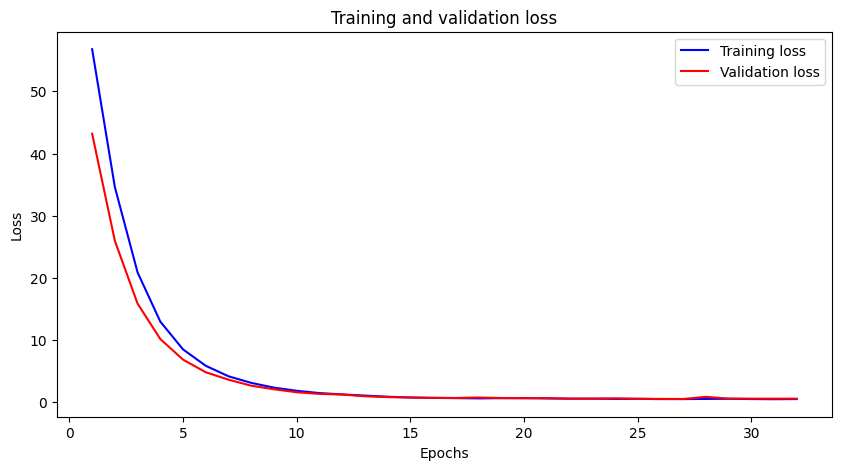

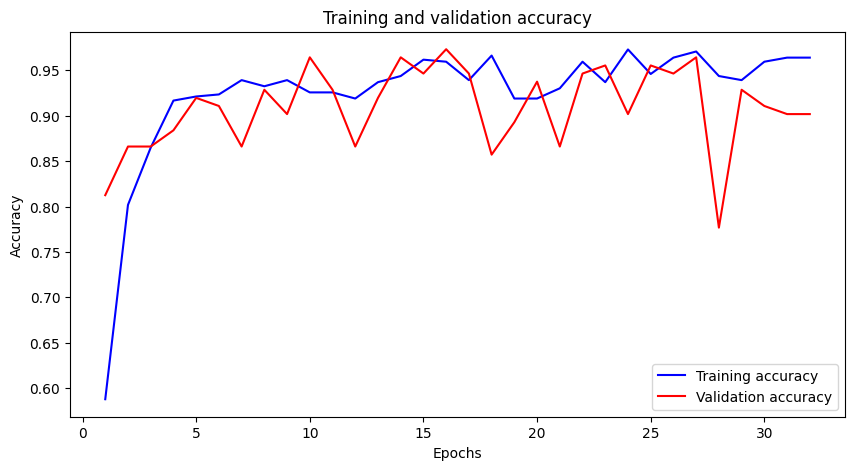

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history_adjusted.history['loss']
val_loss = history_adjusted.history['val_loss']
train_acc = history_adjusted.history['accuracy']
val_acc = history_adjusted.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Define the path to save the model
model_save_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'

# Save the trained model
classifier_model_adjusted.save(model_save_path)

print("Model saved successfully at:", model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at: /content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5


Simple Prediction without preprocessing

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

# Load the trained model
model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

def predict_skin_oiliness(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label

# Upload the image files
uploaded = files.upload()

# Get the list of uploaded image file paths
image_paths = list(uploaded.keys())

# Process and predict for each uploaded image
for image_path in image_paths:
    predicted_class = predict_skin_oiliness(image_path)
    print(f"Prediction for {image_path}: {predicted_class}")

Saving 1000_F_326625213_uHDip2WjaMsEfKpImZ5MDDlrobu2Ui0E_aug_0.jpg to 1000_F_326625213_uHDip2WjaMsEfKpImZ5MDDlrobu2Ui0E_aug_0 (1).jpg
1/1 [==============================] - 0s 89ms/step
Prediction for 1000_F_326625213_uHDip2WjaMsEfKpImZ5MDDlrobu2Ui0E_aug_0 (1).jpg: Normal


Prediction without preprocessing (sidebyside represenation)

Saving 1000_F_326625213_uHDip2WjaMsEfKpImZ5MDDlrobu2Ui0E_aug_0.jpg to 1000_F_326625213_uHDip2WjaMsEfKpImZ5MDDlrobu2Ui0E_aug_0 (2).jpg
1/1 [==============================] - 0s 71ms/step


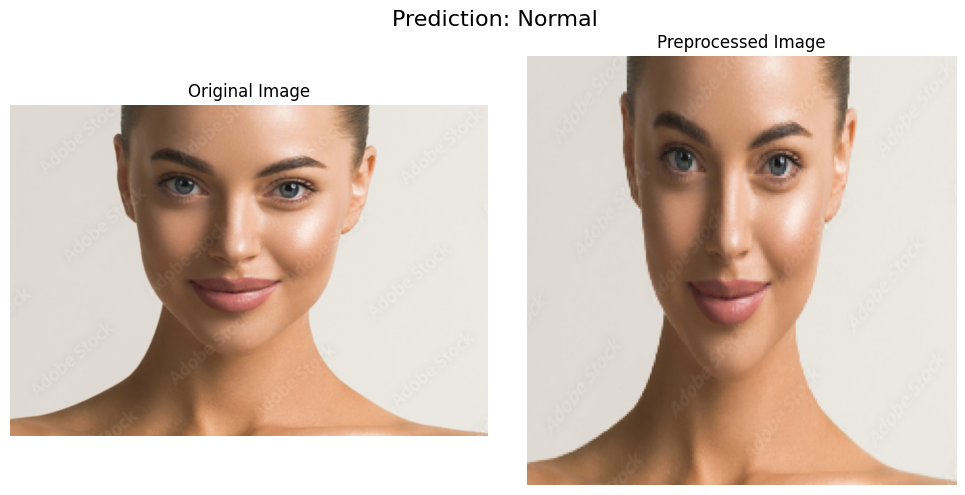

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

def predict_skin_oiliness(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label, img_array

# Upload the image files
uploaded = files.upload()

# Get the list of uploaded image file paths
image_paths = list(uploaded.keys())

# Process, predict, and display for each uploaded image
for image_path in image_paths:
    predicted_class, processed_img = predict_skin_oiliness(image_path)

    # Load the original image
    original_img = image.load_img(image_path)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Display the preprocessed image
    axs[1].imshow(processed_img[0])  # Remove the batch dimension
    axs[1].set_title("Preprocessed Image")
    axs[1].axis('off')

    # Display the prediction
    plt.suptitle(f"Prediction: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

Saving dry 11.jpeg to dry 11.jpeg
1/1 [==============================] - 0s 111ms/step


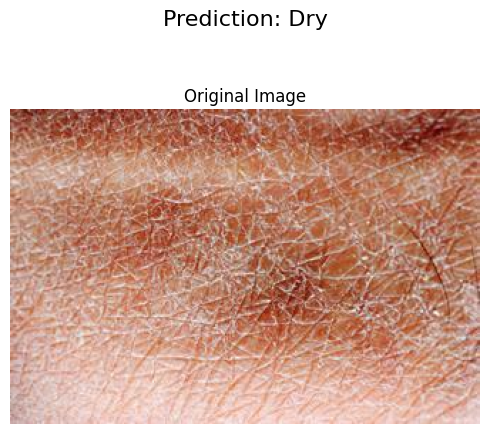

In [84]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

def predict_skin_oiliness(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label

# Upload the image files
uploaded = files.upload()

# Get the list of uploaded image file paths
image_paths = list(uploaded.keys())

# Process, predict, and display for each uploaded image
for image_path in image_paths:
    predicted_class = predict_skin_oiliness(image_path)

    # Load the original image
    original_img = image.load_img(image_path)

    # Create a figure with one subplot
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figure size as needed

    # Display the original image
    ax.imshow(original_img)
    ax.set_title("Original Image")
    ax.axis('off')

    # Display the prediction as the figure title
    fig.suptitle(f"Prediction: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

Prediction with Preprocessing

Saving 18vsvst_aug_2.jpg to 18vsvst_aug_2.jpg
1/1 [==============================] - 0s 278ms/step
Face cropped and saved successfully: face_image_1.jpg
1/1 [==============================] - 0s 112ms/step


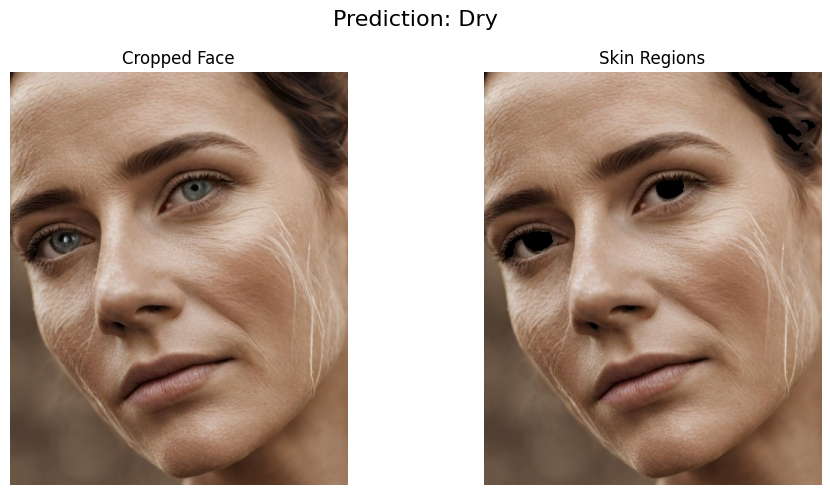

In [98]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import cv2

# Load the trained model
model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

# Function to predict skin oiliness
def predict_skin_oiliness(image_array):
    # Preprocess the image
    img_array = cv2.resize(image_array, target_size)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    img_array = tf.cast(img_array, tf.float32)

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label

# Function to detect faces and save cropped face
def detect_and_save_face(image_path, output_path):
    # Read the input image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load the MTCNN face detection model
    mtcnn = MTCNN()

    # Detect faces in the image
    detections = mtcnn.detect_faces(img_rgb)

    # Check if any faces were detected
    if detections:
        # Extract the first detected face
        x, y, width, height = detections[0]['box']

        # Crop the face region
        face_img = img[y:y+height, x:x+width]

        # Save the cropped face image
        cv2.imwrite(output_path, face_img)
        print(f"Face cropped and saved successfully: {output_path}")
        return True
    else:
        print(f"No faces were detected in the image: {image_path}")
        return False

# Function to detect skin regions
def skin_detection(image):
    # Convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define lower and upper thresholds for skin color in YCrCb space
    lower = np.array([0, 135, 85], dtype=np.uint8)
    upper = np.array([255, 180, 135], dtype=np.uint8)

    # Create a binary mask to detect skin regions
    mask = cv2.inRange(ycrcb, lower, upper)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

# Function to display skin regions and predict oiliness
def display_skin_regions(image):
    # Detect skin regions
    skin_mask = skin_detection(image)
    skin_regions = cv2.bitwise_and(image, image, mask=skin_mask)

    # Predict oiliness level
    predicted_class = predict_skin_oiliness(skin_regions)

    # Display skin regions and prediction
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Cropped Face")
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(skin_regions, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Skin Regions")
    axs[1].axis('off')
    plt.suptitle(f"Prediction: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to process images
def process_images(image_paths):
    for i, image_path in enumerate(image_paths):
        output_face_path = f"face_image_{i+1}.jpg"
        if detect_and_save_face(image_path, output_face_path):
            # Read the cropped face image
            face_img = cv2.imread(output_face_path)

            # Display skin regions and predict
            display_skin_regions(face_img)
        else:
            # If no face is detected, extract skin regions from whole image
            img = cv2.imread(image_path)
            skin_mask = skin_detection(img)
            if np.any(skin_mask):
                skin_regions = cv2.bitwise_and(img, img, mask=skin_mask)
                predicted_class = predict_skin_oiliness(skin_regions)
                # Display skin regions and prediction
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axs[0].set_title("Original Image")
                axs[0].axis('off')
                axs[1].imshow(cv2.cvtColor(skin_regions, cv2.COLOR_BGR2RGB))
                axs[1].set_title("Skin Regions")
                axs[1].axis('off')
                plt.suptitle(f"Prediction: {predicted_class}", fontsize=16)
                plt.tight_layout()
                plt.show()
            else:
                # If no skin regions, display original image
                cv2_imshow(img)

# Upload the image files
uploaded = files.upload()

# Get the list of uploaded image file paths
image_paths = list(uploaded.keys())

# Process and predict for each uploaded image
process_images(image_paths)

Prediction of a webcam captured image without preprocessing

<IPython.core.display.Javascript object>

Saved to photo.jpg


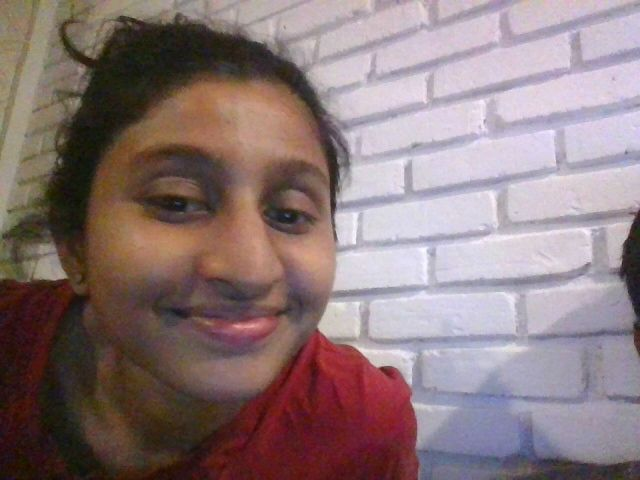

1/1 [==============================] - 0s 28ms/step
Predicted Skin Oiliness Level: Oily


In [106]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from base64 import b64decode
from IPython.display import display, Javascript, Image

# Load the trained model (assuming it's already loaded)
 #model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
 #model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

def predict_skin_oiliness(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Capture image and predict oiliness level
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the captured image
  display(Image(filename))

  # Predict oiliness level
  predicted_class = predict_skin_oiliness(filename)
  print("Predicted Skin Oiliness Level:", predicted_class)

except Exception as err:
  print(str(err))

Code to Capture an image from webcam

In [61]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


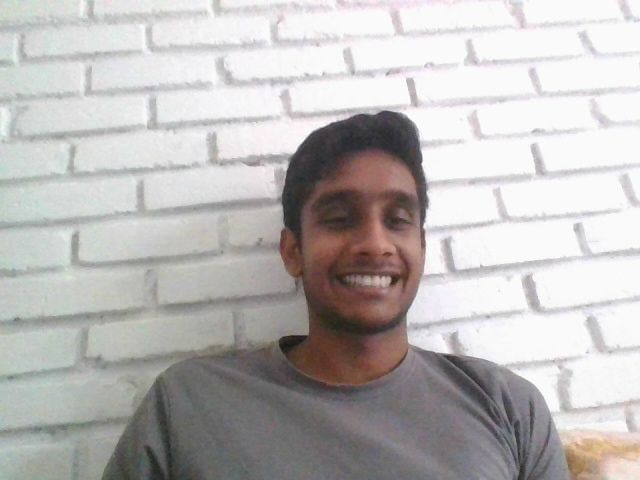

In [62]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Capture the image and predict the oiliness level

<IPython.core.display.Javascript object>

Saved to photo.jpg


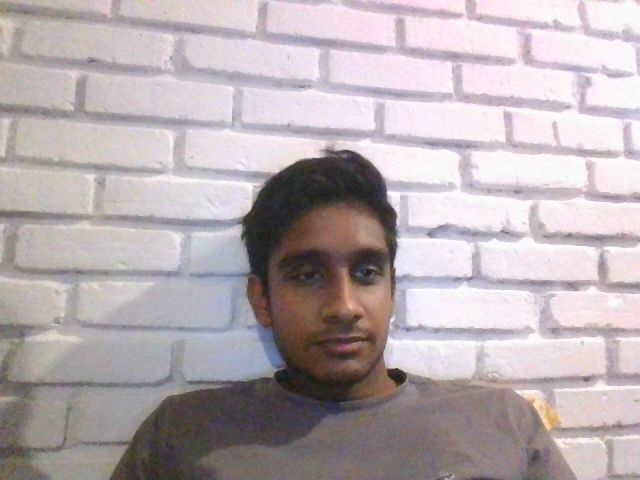

1/1 [==============================] - 0s 172ms/step
Face cropped and saved successfully: webcam_face.jpg
1/1 [==============================] - 0s 78ms/step


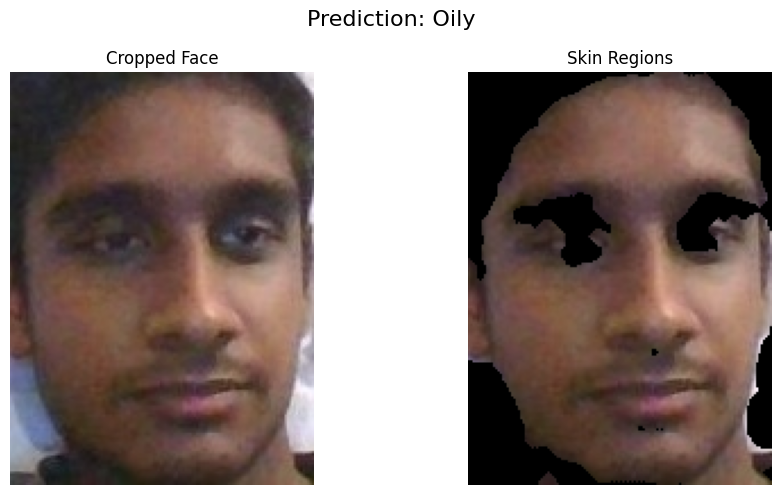

In [107]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Load the trained model (ensure correct path)
model_path = '/content/drive/My Drive/skin_oiliness_level_detection/trained_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size for resizing
target_size = (224, 224)

# Function to predict skin oiliness
def predict_skin_oiliness(image_array):
# Preprocess the image
    img_array = cv2.resize(image_array, target_size)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    img_array = tf.cast(img_array, tf.float32)

    # Extract features using the pre-trained model (MobileNetV2 in this case)
    features = mobilenet_model(img_array)

    # Make prediction using the extracted features
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    # Get class labels from data generator (assuming you saved it before)
    class_labels = data_generator.class_indices

    # Convert predicted class index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    return predicted_class_label

# Function to detect faces and save cropped face
def detect_and_save_face(image_path, output_path):
    # Read the input image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load the MTCNN face detection model
    mtcnn = MTCNN()

    # Detect faces in the image
    detections = mtcnn.detect_faces(img_rgb)

    # Check if any faces were detected
    if detections:
        # Extract the first detected face
        x, y, width, height = detections[0]['box']

        # Crop the face region
        face_img = img[y:y+height, x:x+width]

        # Save the cropped face image
        cv2.imwrite(output_path, face_img)
        print(f"Face cropped and saved successfully: {output_path}")
        return True
    else:
        print(f"No faces were detected in the image: {image_path}")
        return False

# Function to detect skin regions
def skin_detection(image):
    # Convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define lower and upper thresholds for skin color in YCrCb space
    lower = np.array([0, 135, 85], dtype=np.uint8)
    upper = np.array([255, 180, 135], dtype=np.uint8)

    # Create a binary mask to detect skin regions
    mask = cv2.inRange(ycrcb, lower, upper)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

def display_skin_regions(image):
    # Detect skin regions
    skin_mask = skin_detection(image)
    skin_regions = cv2.bitwise_and(image, image, mask=skin_mask)

    # Predict oiliness level
    predicted_class = predict_skin_oiliness(skin_regions)

    # Display skin regions and prediction
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Cropped Face")
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(skin_regions, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Skin Regions")
    axs[1].axis('off')
    plt.suptitle(f"Prediction: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Function to process an image from webcam
def process_webcam_image(image_path):
    if detect_and_save_face(image_path, "webcam_face.jpg"):
        # Read the cropped face image
        face_img = cv2.imread("webcam_face.jpg")
        display_skin_regions(face_img)
    else:
        # If no face detected, try with whole image
        img = cv2.imread(image_path)
        skin_mask = skin_detection(img)
        if np.any(skin_mask):
            skin_regions = cv2.bitwise_and(img, img, mask=skin_mask)
            predicted_class = predict_skin_oiliness(skin_regions)
            # Display results
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Captured Image")
            axs[0].axis('off')
            axs[1].imshow(cv2.cvtColor(skin_regions, cv2.COLOR_BGR2RGB))
            axs[1].set_title("Skin Regions")
            axs[1].axis('off')
            plt.suptitle(f"Prediction: {predicted_class}", fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            cv2_imshow(img)

# Webcam capture function (provided by you)
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Capture image from webcam and process it
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
  # Process the captured image
  process_webcam_image(filename)
except Exception as err:
  print(str(err))